In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"
os.environ["OMP_NUM_THREADS"] = "1"
import katdal
import numpy as np
import matplotlib.pylab as plt
import astropy.coordinates as ac
import functools
import healpy as hp
import optparse
import warnings
from matplotlib.backends.backend_pdf import PdfPages
import healpy as hp
from astropy import units as u
from matplotlib.offsetbox import AnchoredText
import time
import pickle
import sys
Tcmb=2.725
import katcali
import katcali.visualizer as kv
import katcali.models as km
import katcali.rfi as kr
import katcali.solver as ks
import katcali.io as kio
import katcali.label_dump as kl
import katcali.diode as kd
import katcali.filter as kf
import katcali.beam as kb
from astropy.coordinates import SkyCoord
from astropy import units as u
from scipy.sparse import coo_matrix
import astropy.wcs
from astropy.wcs.utils import skycoord_to_pixel
from astropy.wcs.utils import pixel_to_skycoord
from astropy.io import fits
from astropy.wcs import WCS

In [2]:
print ('start @ ' + time.asctime(time.localtime(time.time())) +'...')

start @ Mon Jun 16 14:11:39 2025...


In [3]:
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])
plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 14, 1.5, 1.5
#plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'] = 10.0, 0.8, 1.5
print  (plt.rcParams['font.size'], plt.rcParams[u'axes.linewidth'],plt.rcParams['lines.linewidth'])

10.0 0.8 1.5
14.0 1.5 1.5


In [4]:
p_radec=np.loadtxt('radio_source_fsky.txt')

In [5]:
ch_plot=3200

In [6]:
# input_name = "level4_1675210948_20250607_124705"
# fname='1675210948'
# ant='m001'
input_name = "level4_1675623808_20250607_120732"
fname='1675623808'
ant='m001'

print (fname, ant)

1675623808 m001


In [7]:
#input_file='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level4/data/'
input_file=f'../level4/results/py_results/{input_name}/{fname}_{ant}/'
output_file='./results/jupyter_results/'

In [8]:
d1=pickle.load(open(input_file+fname+'_'+ant+'_level4_data','rb'), encoding='latin-1')
print (d1.keys())

dict_keys(['Tsky_map', 'Tresi_map', 'Tsky_ratio', 'timestamps', 'ra', 'dec', 'nd_s0_h', 'nd_s0_v'])


<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


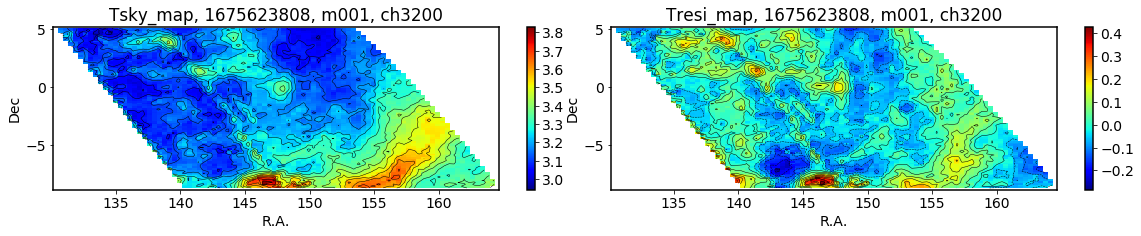

In [9]:
ra=d1['ra']
dec=d1['dec']
Tresi_map=d1['Tresi_map']
Tsky_map=d1['Tsky_map']
nd_s0=d1['nd_s0_h']
plt.figure(figsize=(20,3))
plt.subplots_adjust (wspace=0.0, hspace=0.2) 
plt.subplot(121)
p_data=Tsky_map[:,ch_plot]
try:
    kv.plot_data(ra,dec, p_data,gsize=90)
except(Exception):
    kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('Tsky_map, '+fname+', '+ant+', ch'+str(ch_plot))
plt.subplot(122)
p_data=Tresi_map[:,ch_plot]
try:
    kv.plot_data(ra,dec, p_data,gsize=90)
except(Exception):
    kv.plot_data(ra,dec, np.zeros_like(ra),gsize=90)
plt.xlabel('R.A.')
plt.ylabel('Dec')
plt.title('Tresi_map, '+fname+', '+ant+', ch'+str(ch_plot))
plt.show()

In [10]:
freqs=kio.cal_freqs_UHF(range(4096))
freqs = np.array(freqs)

<class 'numpy.ma.core.MaskedArray'>
<class 'numpy.ma.core.MaskedArray'>


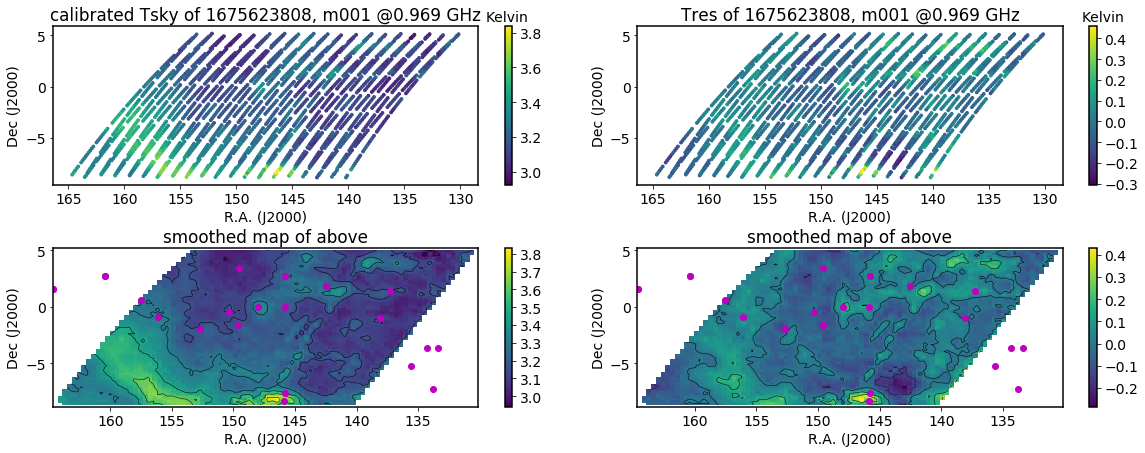

In [11]:
plot_gsize=90
plt.figure(figsize=(20,7))
plt.subplots_adjust(wspace=0.1,hspace=.4)
ax=plt.subplot(221)
p_data=Tsky_map[:,ch_plot]
plt.scatter(ra,dec, c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8, cmap=kv.cmap1())
ax.invert_xaxis()
plt.title('calibrated Tsky of '+str(fname)+', '+str(ant)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
ax=plt.subplot(222)
p_data=Tresi_map[:,ch_plot]
plt.scatter(ra,dec, c=p_data, vmin=p_data.min(),vmax=p_data.max(), s=8, cmap=kv.cmap1())
ax.invert_xaxis()
plt.title('Tres of '+str(fname)+', '+str(ant)+ ' @'+ str(round(freqs[ch_plot]/1e9,3))+' GHz')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
clb = plt.colorbar()
clb.set_label('Kelvin', labelpad=-35, y=1.1, rotation=0)
ax=plt.subplot(223)
p_data=Tsky_map[nd_s0,ch_plot]
kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize, grid_method='linear', levels=6, x_mask=1, y_mask=2, cmap=kv.cmap1())
ax.invert_xaxis()
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('smoothed map of above')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
ax=plt.subplot(224)
p_data=Tresi_map[nd_s0,ch_plot]
kv.plot_mdata(ra[nd_s0],dec[nd_s0], p_data,gsize=plot_gsize, grid_method='linear', levels=6, x_mask=1, y_mask=2, cmap=kv.cmap1())
ax.invert_xaxis()
plt.plot(p_radec[:,0],p_radec[:,1],'mo')
plt.title('smoothed map of above')
plt.xlabel('R.A. (J2000)')
plt.ylabel('Dec (J2000)')
#plt.savefig('F_calibrated_map.pdf', bbox_inches='tight')
plt.show()

In [12]:
#set the sky area to be pixelized 
x_cen=149 #deg #RA
x_half=26 #deg

y_cen=-4#deg #DEC
y_half=12#deg

pix_deg=0.3

N_half_x=int(x_half/pix_deg)
N_half_y=int(y_half/pix_deg)
Npix_x=2*N_half_x+1
Npix_y=2*N_half_y+1

print (Npix_x,Npix_y)

173 81


In [13]:
p_choice='ZEA'

In [14]:
w = astropy.wcs.WCS(naxis=2)
w.wcs.crval = [x_cen-x_half, y_cen-y_half] # reference pointing of the image #deg
w.wcs.crpix = [1.0, 1.0] # pixel index corresponding to the reference pointing (try either 1 or 0 to see if the behaviour agrees to your expectation!)
w.wcs.cdelt = np.array([pix_deg, pix_deg]) # resolution 
#w.wcs.ctype = ['RA---ZEA', 'DEC--ZEA'] #projection 
#w.wcs.ctype = ['RA---AIT', 'DEC--AIT'] #ref_p0 can't go back to zero
w.wcs.ctype = ['RA---'+p_choice, 'DEC--'+p_choice] 

#other choice: https://docs.astropy.org/en/stable/wcs/
#skyview comment: https://skyview.gsfc.nasa.gov/current/help/fields.html#Projection

In [15]:
print (w)

WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Data size  Bounds
        0       None  None
        1       None  None

World Dim  Physical Type  Units
        0  pos.eq.ra
        1  pos.eq.dec

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes


In [16]:
##check the (min ra, min dec) of sky area will fall into pix (0,0)
p0=ac.SkyCoord(ra=(x_cen-x_half)*u.deg, dec=(y_cen-y_half)*u.deg) 
ref_p=skycoord_to_pixel(p0, w)
print (ref_p[0],ref_p[1])
assert(ref_p[0]<1e-12) #should be zero
assert(ref_p[1]<1e-12) #shoule be zero

0.0 0.0


In [17]:
p_list=ac.SkyCoord(ra=ra*u.deg, dec=dec*u.deg) #pointings in observation
x_pix_list,y_pix_list=skycoord_to_pixel(p_list,w) #observation (ra,dec) to pix

x_pix_list=np.round(x_pix_list).astype(int)
y_pix_list=np.round(y_pix_list).astype(int)

In [18]:
#out range due to track data, will filter when add to the map cube
print (np.min(x_pix_list),np.max(x_pix_list),Npix_x)
print (np.min(y_pix_list),np.max(y_pix_list),Npix_y)

-101 156 173
-216 70 81


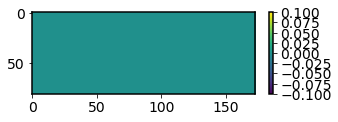

In [19]:
fits_temp=np.zeros([Npix_x,Npix_y,4096])
plt.figure(figsize=(5,1.5))
plt.imshow(fits_temp[:,:,ch_plot].T,aspect='auto')
plt.colorbar()
plt.show()

In [20]:
Sum_Tsky_xy=fits_temp.copy()
Sum_Tresi_xy=fits_temp.copy()
Npix_xy_count1=fits_temp.copy()
Npix_xy_count2=fits_temp.copy()

In [21]:
assert((Tsky_map.mask==Tresi_map.mask).all()==True)

In [22]:
for i in range(len(ra)):
    x_pix,y_pix=x_pix_list[i],y_pix_list[i]
    
    mask1=Tsky_map.mask[i,:]
    if (mask1==True).all()==False:
        Sum_Tsky_xy[x_pix,y_pix,~mask1]+=Tsky_map[i,~mask1]
        Npix_xy_count1[x_pix,y_pix,~mask1]+=1
    
    mask2=Tresi_map.mask[i,:]
    if (mask2==True).all()==False:
        Sum_Tresi_xy[x_pix,y_pix,~mask2]+=Tresi_map[i,~mask2]
        Npix_xy_count2[x_pix,y_pix,~mask2]+=1

In [23]:
np.shape(Sum_Tsky_xy)

(173, 81, 4096)

In [24]:
x_pix

154

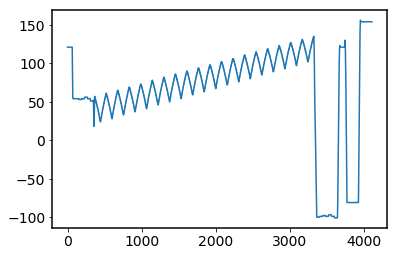

In [25]:
plt.plot(x_pix_list)

In [26]:
assert((Npix_xy_count1==Npix_xy_count2).all())

In [27]:
Tsky_xy=Sum_Tsky_xy/Npix_xy_count1
Tresi_xy=Sum_Tresi_xy/Npix_xy_count2

/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:1: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':
/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:2: RuntimeWarning: invalid value encountered in true_divide
  from ipykernel import kernelapp as app


In [28]:
ptr_list=ac.SkyCoord(ra=p_radec[:,0]*u.deg, dec=p_radec[:,1]*u.deg)
ptr_ra_pix,ptr_dec_pix=skycoord_to_pixel(ptr_list,w)

In [29]:
for i in range(len(ptr_list)):
    print (ptr_ra_pix[i],ptr_dec_pix[i])
tmp = np.column_stack((ptr_ra_pix, ptr_dec_pix))  # 合并为两列数据
np.savetxt(f"radio_sourceUHF_pix_{pix_deg}deg.txt", tmp, fmt="%.5f", delimiter="\t", comments="")
del tmp

-185.09101197351296 277.1172787807563
-262.92820912550053 213.73341315380497
-134.08752461341064 298.8650467156327
-136.82103332217525 -243.68308482162524
-282.8822279798147 -150.01243704437695
-335.9178631841146 30.719576053628202
-335.55072065868984 28.968374283054654
-335.50638670373075 28.960807484051628
-107.68889890871307 305.144769983275
-130.32174361271797 -243.8148848859991
-187.65895733204147 -226.0634665122847
-313.85587279135615 -92.51557972101197
-25.126561989221102 -238.22084341494713
-326.1933219555962 -55.36608709959232
-314.3035315481921 -88.67368902942927
-333.5226057718753 29.898929213359693
-181.12580349938546 -226.76149045008086
-191.38609982119138 -221.86032213742308
-128.9007079872467 298.2611964150979
-62.44831229091161 309.9528072815254
-325.4287397218101 -45.777367873369215
-325.4293282978388 -45.769950567973474
-62.39676624961182 309.9156703457808
-324.43978585033557 85.35723869619046
-261.72799433240624 209.32723925883542
-286.9427891476652 174.6716845038028

In [33]:
Tsky_xy

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

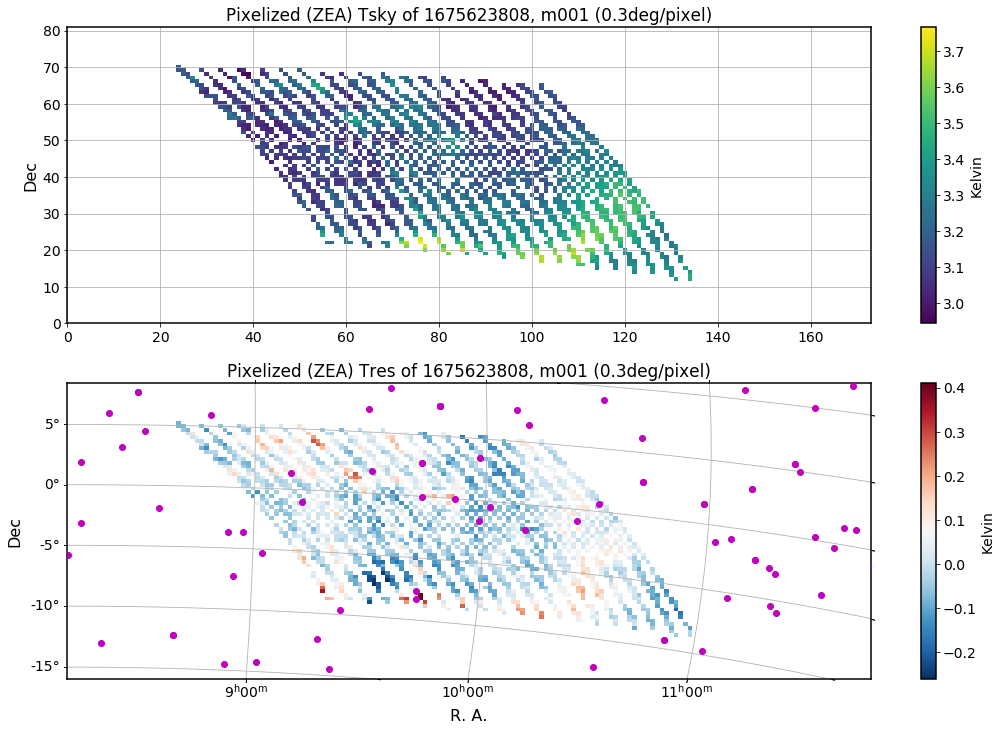

In [37]:
plt.figure(figsize=(18,12))
plt.subplot(211)
plt.imshow(Tsky_xy[:,:,ch_plot].T,cmap=kv.cmap1(),aspect='auto')
#plt.gca().invert_yaxis() #only works when no coordinates
plt.colorbar(label='Kelvin')
plt.ylabel('Dec',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.grid()
plt.title('Pixelized ('+p_choice+') Tsky of '+fname+', '+ant+' (0.3deg/pixel)')
plt.subplot(212,projection=w)
plt.imshow(Tresi_xy[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto')
#plt.gca().invert_yaxis() #only works when no coordinates
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=16)
plt.ylabel('Dec',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.grid()
plt.title('Pixelized ('+p_choice+') Tres of '+fname+', '+ant+' (0.3deg/pixel)')
plt.show()

In [31]:
assert((Npix_xy_count1==Npix_xy_count2).all())


In [32]:
print (w)

WCS Transformation

This transformation has 2 pixel and 2 world dimensions

Array shape (Numpy order): None

Pixel Dim  Data size  Bounds
        0       None  None
        1       None  None

World Dim  Physical Type  Units
        0  pos.eq.ra      deg
        1  pos.eq.dec     deg

Correlation between pixel and world axes:

           Pixel Dim
World Dim    0    1
        0  yes  yes
        1  yes  yes


In [33]:
list=[Sum_Tsky_xy,Sum_Tresi_xy,Npix_xy_count1,Tsky_xy,Tresi_xy]
list_str=['Sum_Tsky_xy','Sum_Tresi_xy','Npix_xy_count','Tsky_xy','Tresi_xy']
for i in range(len(list)):
    hdu=w.to_fits()
    hdu[0].data=list[i]
    hdu.writeto(output_file+fname+'_'+ant+'_'+list_str[i]+'_p'+str(pix_deg)+'d.fits', overwrite=True)

In [34]:
# end

# reload data to check 

In [ ]:
Fits='/idia/projects/hi_im/raw_vis/MeerKLASS2021/level5/data/'+fname+'_'+ant+'_'+list_str[-1]+'_p'+str(pix_deg)+'d.fits'
cube = fits.open(Fits)[0].data
cube = fits.open(Fits)[0].data
print (np.shape(cube))

In [ ]:
w2=WCS(Fits).dropaxis(-1)
print (w2)

In [ ]:
#check data
assert((cube[~np.isnan(cube)]==Tresi_xy[~np.isnan(Tresi_xy)]).all()==True)

In [ ]:
plt.figure(figsize=(18,5))
plt.subplot(projection=w2)
plt.imshow(cube[:,:,ch_plot].T,cmap=kv.cmap2(),aspect='auto')
plt.plot(ptr_ra_pix,ptr_dec_pix,'mo')
plt.plot(ptr_ra_pix[22],ptr_dec_pix[22],'mo',ms=12)
plt.colorbar(label='Kelvin')
plt.xlabel('R. A.',fontsize=16)
plt.ylabel('Dec',fontsize=16)
plt.xlim([0,Npix_x])
plt.ylim([0,Npix_y])
plt.show()

In [ ]:
print ('end @ ' + time.asctime(time.localtime(time.time())) +'#')